# Read in the data

In [55]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [ ]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

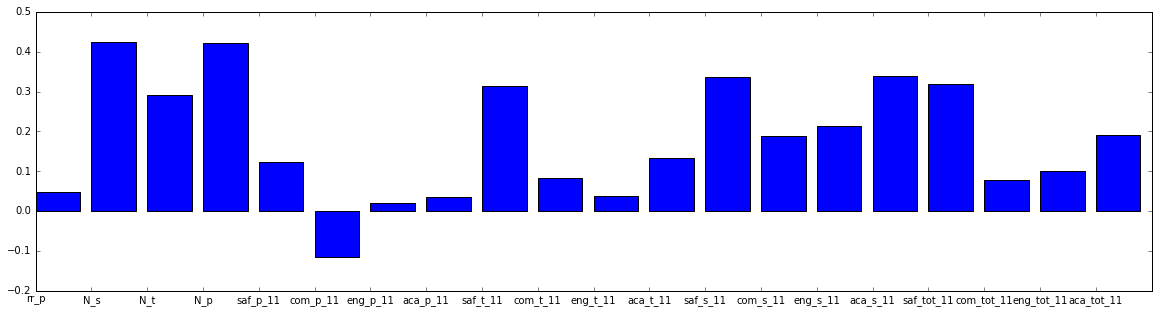

In [49]:
# Plot bar chart of survey correlations. This is between a survey of parents, teachers, and students compared to SAT score 
plt.bar(range(len(correlations.loc[[
    "rr_p", 
        "N_s", 
        "N_t", 
        "N_p", 
        "saf_p_11", 
        "com_p_11", 
        "eng_p_11", 
        "aca_p_11", 
        "saf_t_11", 
        "com_t_11", 
        "eng_t_11", 
        "aca_t_11", 
        "saf_s_11", 
        "com_s_11", 
        "eng_s_11", 
        "aca_s_11", 
        "saf_tot_11", 
        "com_tot_11", 
        "eng_tot_11", 
        "aca_tot_11"
]])), correlations.loc[[
    "rr_p", 
        "N_s", 
        "N_t", 
        "N_p", 
        "saf_p_11", 
        "com_p_11", 
        "eng_p_11", 
        "aca_p_11", 
        "saf_t_11", 
        "com_t_11", 
        "eng_t_11", 
        "aca_t_11", 
        "saf_s_11", 
        "com_s_11", 
        "eng_s_11", 
        "aca_s_11", 
        "saf_tot_11", 
        "com_tot_11", 
        "eng_tot_11", 
        "aca_tot_11"
]]
)
plt.xticks(range(len(correlations.loc[[
    "rr_p", 
        "N_s", 
        "N_t", 
        "N_p", 
        "saf_p_11", 
        "com_p_11", 
        "eng_p_11", 
        "aca_p_11", 
        "saf_t_11", 
        "com_t_11", 
        "eng_t_11", 
        "aca_t_11", 
        "saf_s_11", 
        "com_s_11", 
        "eng_s_11", 
        "aca_s_11", 
        "saf_tot_11", 
        "com_tot_11", 
        "eng_tot_11", 
        "aca_tot_11"
]])), [
    "rr_p", 
        "N_s", 
        "N_t", 
        "N_p", 
        "saf_p_11", 
        "com_p_11", 
        "eng_p_11", 
        "aca_p_11", 
        "saf_t_11", 
        "com_t_11", 
        "eng_t_11", 
        "aca_t_11", 
        "saf_s_11", 
        "com_s_11", 
        "eng_s_11", 
        "aca_s_11", 
        "saf_tot_11", 
        "com_tot_11", 
        "eng_tot_11", 
        "aca_tot_11"
])

plt.figure(figsize=(1,1))
plt.show()

We see a moderate correlations for N_s (number of student respondents) and N_p (number of parent parent respondents), which means that there is a positive correlation between the number of students/parents who responded and their SAT score. Perhaps more involved students/parents are more likely to get a better SAT score.

## Perceived Safety

We also notice that saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated modestly with sat_score. We'll dig into this relationship a bit more, and try to figure out which schools have low safety scores:

<function matplotlib.pyplot.show>

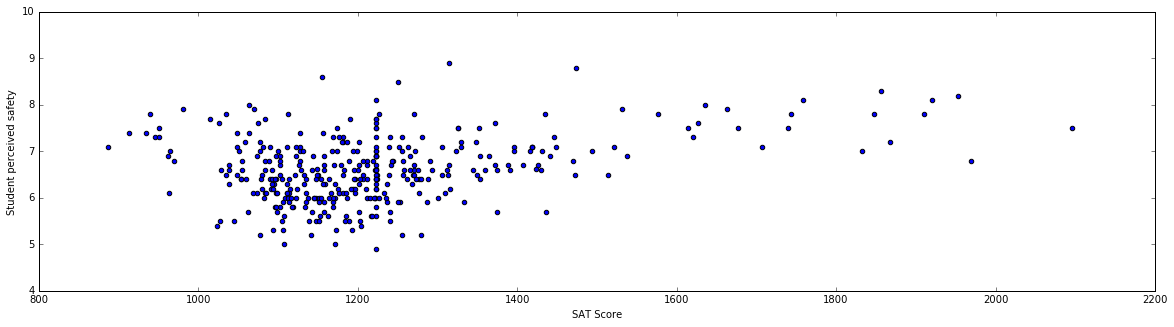

In [51]:
plt.scatter(combined['sat_score'], combined['saf_s_11'])
plt.xlabel('SAT Score')
plt.ylabel('Student perceived safety')
plt.show

<function matplotlib.pyplot.show>

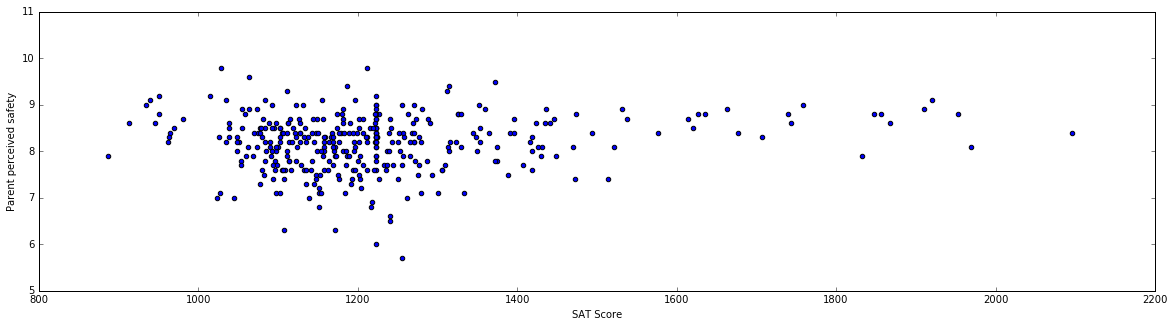

In [53]:
plt.scatter(combined['sat_score'], combined['saf_p_11'])
plt.xlabel('SAT Score')
plt.ylabel('Parent perceived safety')
plt.show

Student and Parent perceptions are similar so we'll focus just on student's perceptions.

In [62]:
#Compute the average safety score for each district
combined['district'] = combined['DBN'].apply(lambda x: x[0:2]) #district is first two chars from DBN
districts = combined.groupby('district').agg(np.mean)
districts.reset_index(inplace=True)
districts

,district,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


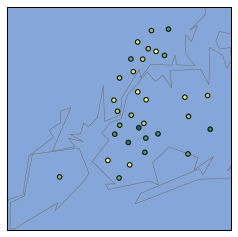

In [63]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

From the above map it appears that perceived student safety follows some geographcial borders

## Race

There are a few columns that indicate the percentage of each race at a given school:
- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

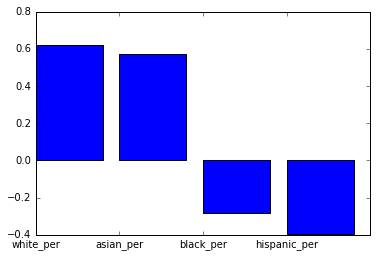

In [64]:
# Make a bar plot of the correlations between the race columns and sat_score
plt.bar(range(len(correlations.loc[[
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per'
]])), correlations.loc[[
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per'
]]
)
plt.xticks(range(len(correlations.loc[[
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per'
]])), [
    'white_per',
    'asian_per',
    'black_per',
    'hispanic_per'
])

plt.figure(figsize=(1,1))
plt.show()

Above we see a positive correlation for SAT score compared to whites and asians. We see a negative correlation for blacks and hispanics.

<function matplotlib.pyplot.show>

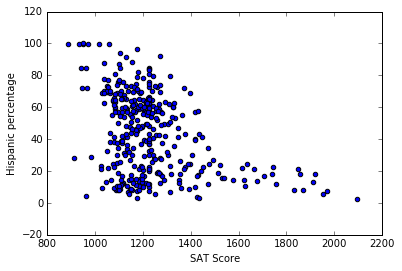

In [65]:
#scatter plot of hispanic_per vs. sat_score
plt.scatter(combined['sat_score'], combined['hispanic_per'])
plt.xlabel('SAT Score')
plt.ylabel('Hispanic percentage')
plt.show

The above plot shows a distinct negative correlation between hispanic percentage and SAT score. There is however, a large grouping in the middle that apperas to be agnostic of the hispanic percentage.

In [81]:
most_hispanic_schools = combined[combined['hispanic_per'] > 95]
most_hispanic_schools[['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


The schools above have a hispanic percentage greater than 95%. Reviewing search results on Google we find that these schools are primarily serving newly arrived immigrants who are English language learners.

In [94]:
highSAT_lowHispanic = combined[combined['hispanic_per'] < 10]
highSAT_lowHispanic = highSAT_lowHispanic[highSAT_lowHispanic['sat_score'] > 1800]
highSAT_lowHispanic[['SCHOOL NAME', 'hispanic_per', 'sat_score']].sort_values(by=['sat_score'], ascending=False)

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0


The above schools appear to be magnet schools and are more exclusive to gain entrance to

## Gender

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:13: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



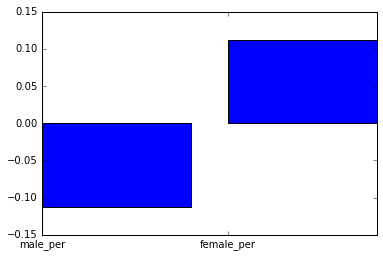

In [88]:
#Let's look at the percentage of gender to SAT scores
#Make a bar chart
plt.bar(range(len(correlations.loc[[
    'male_per',
    'female_per'
]])), correlations.loc[[
    'male_per',
    'female_per'
]]
)
plt.xticks(range(len(correlations.loc[[
    'male_per',
    'feamle_per'
]])), [
    'male_per',
    'female_per'
])

plt.figure(figsize=(1,1))
plt.show()

There appears to be a positive correlation between being female and higher SAT scores

<function matplotlib.pyplot.show>

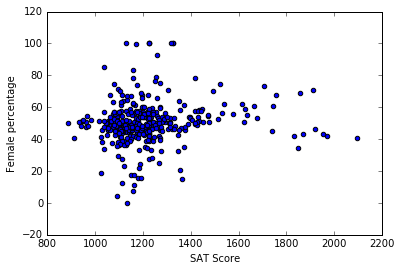

In [89]:
#scatter plot of female_per vs. sat_score
plt.scatter(combined['sat_score'], combined['female_per'])
plt.xlabel('SAT Score')
plt.ylabel('Female percentage')
plt.show

The above scatterplot shows a modest positive correlation between being female and elevated SAT scores.

In [95]:
#Investigate schools with high SAT scores and a high female_per.
highSAT_highfemale = combined[combined['female_per'] > 60]
highSAT_highfemale = highSAT_highfemale[highSAT_highfemale['sat_score'] > 1700]
highSAT_highfemale[['SCHOOL NAME', 'female_per', 'sat_score']].sort_values(by=['sat_score'], ascending=False)

,SCHOOL NAME,female_per,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0


Performing some cursory resarch online none of these schools seem to be predominately female for any noteable reason. The schools, like the high performing ones earlier in this analysis, are magnet schools.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

## AP Exams

In [97]:
#Calculate the percentage of students in each school that took an AP exam.
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per'].head(5)

0    0.305756
1    0.098985
2    0.031773
3    0.351577
4    0.158091
Name: ap_per, dtype: float64

<function matplotlib.pyplot.show>

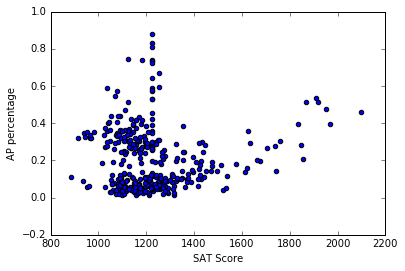

In [98]:
#scatter plot of ap_per vs. sat_score
plt.scatter(combined['sat_score'], combined['ap_per'])
plt.xlabel('SAT Score')
plt.ylabel('AP percentage')
plt.show

The scatterplot above reveals a modest postivite correlation between percentage of students in each school that took an AP exam and increased SAT scores

We've done quite a bit of investigation into relationships between demographics and SAT scores in this  project. There's still quite a bit of analysis left to do, however. Here would be some potential next steps:

- Determing wheter there's a correlation between class size and SAT scores
- Figuring out which neighborhoods have the best schools
- If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
- Investigating the differences between parent, teacher, and student responses to surveys.
- Assigning scores to schools based on sat_score and other attributes.